# GIC Sensitivity Analysis

Demonstrates the E-field-to-GIC Jacobian ($dI/dE$) for identifying which
transformers and branches are most sensitive to E-field perturbations. The
notebook builds the GIC model, computes the Jacobian, ranks transformers
by overall sensitivity, identifies critical branches by column analysis,
and profiles directional vulnerability for selected transformers.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from esapp import PowerWorld
from esapp.components import Bus, GICXFormer
from examples.map import format_plot

In [ ]:
# This cell is hidden in the documentation.
import ast

with open('../data/case.txt', 'r') as f:
    case_path = ast.literal_eval(f.read().strip())

pw = PowerWorld(case_path)

In [3]:
# Plotting functions (hidden from documentation)
import sys; sys.path.insert(0, "..")
from plot_helpers import (
    plot_jacobian_sensitivity, plot_branch_impact,
    plot_direction_profiles,
)

## 1. Build the GIC Model

The sensitivity analysis requires the H-matrix from `model()`.

In [ ]:
pw.gic.configure()
pw.gic.model()

# Apply a baseline storm to get signed currents
pw.gic.storm(1.0, 90)
gic_baseline = pw[GICXFormer, 'GICXFNeutralAmps']['GICXFNeutralAmps'].to_numpy()

## 2. E-Field to GIC Jacobian (dI/dE)

The `dIdE()` method computes the Jacobian of absolute transformer GICs with respect
to the electric field components. This identifies which E-field perturbations have
the greatest effect on each transformer.

In [ ]:
# Compute dI/dE Jacobian using H-matrix and baseline currents
J = pw.gic.dIdE(pw.gic.H, i=gic_baseline)

print(f"dI/dE Jacobian shape: {J.shape}")
print(f"  Rows: {J.shape[0]} (transformers)")
print(f"  Cols: {J.shape[1]} (branch voltages)")

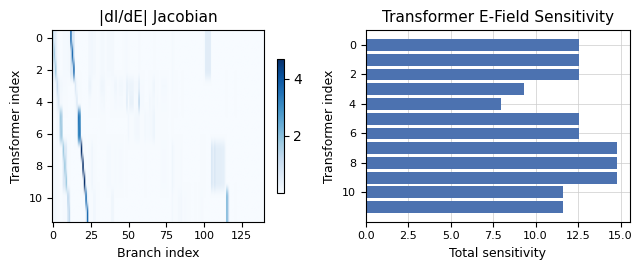

In [6]:
J_dense = J if isinstance(J, np.ndarray) else J.toarray()
plot_jacobian_sensitivity(J_dense)

## 3. Most Sensitive Transformers

Identify which transformers are most sensitive to E-field perturbations.

In [11]:
# Rank transformers by total sensitivity
sensitivity = np.sum(np.abs(J_dense), axis=1)
ranked = np.argsort(sensitivity)[::-1]

print(f"{'Rank':<6} {'XF Index':<10} {'Total Sensitivity':<20}")
print("-" * 36)
for rank, idx in enumerate(ranked[:10]):
    print(f"{rank + 1:<6} {idx:<10} {sensitivity[idx]:<20.4f}")

Rank   XF Index   Total Sensitivity   
------------------------------------
1      8          14.8116             
2      7          14.8116             
3      9          14.8116             
4      1          12.5756             
5      0          12.5756             
6      2          12.5756             
7      6          12.5283             
8      5          12.5283             
9      11         11.5955             
10     10         11.5955             


## 4. Column-Wise Analysis: Critical Branches

Which branches (line voltages) have the greatest aggregate impact on GIC?

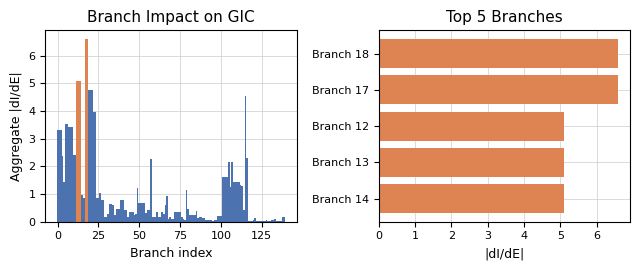


Top 5 most influential branches: [18 17 12 13 14]


In [8]:
col_sens = np.sum(np.abs(J_dense), axis=0)
plot_branch_impact(col_sens)

## 5. Direction Sensitivity Profile

Sweep storm direction and track individual transformer responses to identify
directional vulnerability.

In [ ]:
directions = np.arange(0, 360, 5)
n_xf = min(5, len(gic_baseline))
top_xf_idx = np.argsort(np.abs(gic_baseline))[::-1][:n_xf]

gic_profiles = np.zeros((len(directions), n_xf))

for i, d in enumerate(directions):
    pw.gic.storm(1.0, d)
    gic_vals = pw[GICXFormer, 'GICXFNeutralAmps']['GICXFNeutralAmps'].to_numpy()
    gic_profiles[i] = np.abs(gic_vals[top_xf_idx])

plot_direction_profiles(directions, gic_profiles,
                        labels=[f'XF {idx}' for idx in top_xf_idx])

## Summary

The $dI/dE$ Jacobian maps small E-field perturbations to transformer GIC
changes. Row-wise analysis reveals which transformers are most sensitive
overall, while column-wise analysis identifies the branches that carry the
most GIC influence. Directional profiles show how individual transformer
sensitivity varies with storm orientation.